# Superlative Cities

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [ ]:
data = pd.read_csv('US_Accidents_March23.csv')

### Data cleaning

In [9]:
drop_columns = ['ID', 'Source', 'Start_Time', 'End_Time', 
                 'End_Lat', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
                 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 
                 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

df = data.drop(drop_columns, axis=1)
df["severe"] = (df['Severity'] >= 3).astype(int)

### Identify Cities

In [10]:
def identify_cities(
    df,
    min_samples=1000,
):
    """
    Returns:
        most_dangerous city
        least_dangerous city
    Based on empirical-Bayes shrunken severe-crash probabilities.
    """
    df = df.copy()

    # k successes out of n draws bernoulli
    props_df = df.groupby('City').agg(
        k=('severe', 'sum'),
        n=('severe', 'size')
    )

    # only use cities with more than 1000 (can't do trees on too small a city)
    big_cities_df = props_df[props_df['n'] >= min_samples].copy()
    small_cities_df = props_df[props_df['n'] < min_samples].copy()

    # build a beta prior distribution 

    # get total prob of severe to build prior
    total_k = small_cities_df['k'].sum()
    total_n = small_cities_df['n'].sum()
    mu_hat = total_k / total_n

    # parameters for beta prior:
    # as if we have already seen a big city with prop mu_hat severe accidents
    alpha_prior = mu_hat * 1000
    beta_prior= (1 - mu_hat) * 1000

    # parameters for posterior 
    big_cities_df['alpha_post'] = alpha_prior + big_cities_df['k']
    big_cities_df['beta_post'] = beta_prior + big_cities_df['n'] - big_cities_df['k']

    # MAP estimate for each city:
    # p_map = (alpha_post - 1) / (alpha_post + beta_post - 2)
    big_cities_df['p_map'] = (
        (big_cities_df['alpha_post'] - 1) /
        (big_cities_df['alpha_post'] + big_cities_df['beta_post'] - 2)
    )

    # extract cities with greateset and smallest estimated prop severe accidents
    most_dangerous = big_cities_df["p_map"].idxmax()
    least_dangerous = big_cities_df["p_map"].idxmin()

    return most_dangerous, least_dangerous

print(identify_cities(df))

('Saint Louis', 'Fresno')


### Safe City: Fresno

Text(0.5, 1.0, 'Accidents in Fresno, Least Dangerous City')

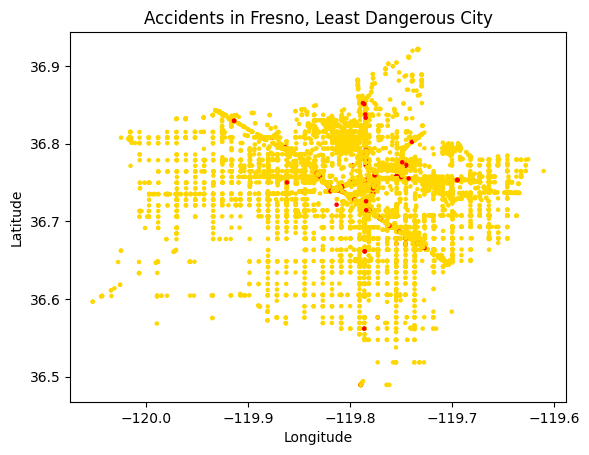

In [11]:
fresno = df.groupby("City").get_group("Fresno")
fresno = fresno[fresno["Start_Lng"] <= -110].copy()   # data cleaning can be adjusted
lat = fresno["Start_Lat"]
long = fresno["Start_Lng"]

color_map = {1: "gold", 2:"gold", 3:"red", 4:"red"}
colors = fresno['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in Fresno, Least Dangerous City")


### Dangerous City: St Louis

Text(0.5, 1.0, 'Accidents in St Louis, Most Dangerous City')

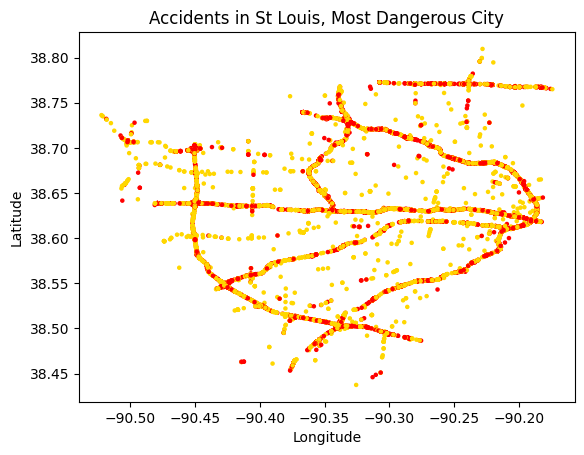

In [16]:
stlouis = df.groupby("City").get_group("Saint Louis")
stlouis = stlouis[stlouis["Start_Lng"] <= -89].copy()   # data cleaning can be adjusted
lat = stlouis["Start_Lat"]
long = stlouis["Start_Lng"]

color_map = {1: "gold", 2:"gold", 3:"red", 4:"red"}
colors = stlouis['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in St Louis, Most Dangerous City")



### Traffic Structure Plots

Text(0.5, -37.61892182230449, 'Presence of Road Feature')

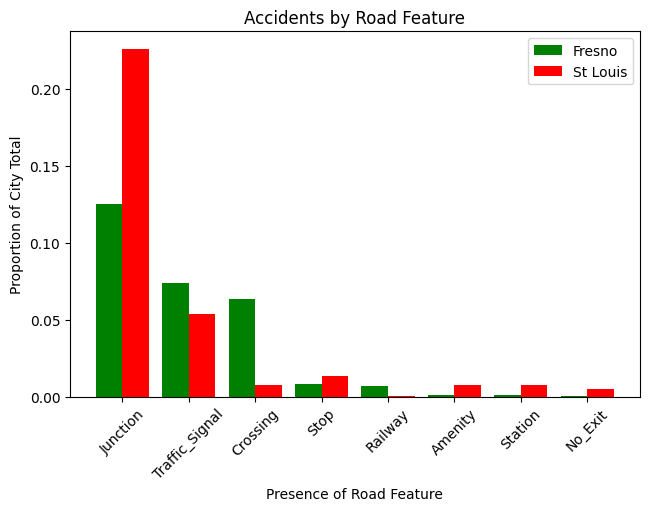

In [147]:
# group by
fresno = df.groupby("City").get_group("Fresno")
total = fresno.shape[0]

traffic_features = ['Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop'
]

# make a df with each traffic feature, number of accidents, and boolean severity
rows = []
for col in traffic_features:
    accident_count = fresno[col].sum()
    rows.append([col, accident_count, accident_count / total])

agg_fresno = pd.DataFrame(rows, columns=['feature', 'accident_count', 'prop'])
propA = agg_fresno.set_index('feature')['prop']
top8 = agg_fresno.sort_values('prop', ascending=False).head(8)['feature'].to_list()

##

# group by 
stlouis = df.groupby("City").get_group("St Louis")
total = stlouis.shape[0]

# make a df with each traffic feature, number of accidents, and boolean severity
rows = []
for col in traffic_features:
    accident_count = stlouis[col].sum()
    rows.append([col, accident_count, accident_count / total])


agg_stlouis = pd.DataFrame(rows, columns=['feature','accident_count', 'prop'])
propB = agg_stlouis.set_index('feature')['prop']

## 

# combine into a plot with subplots
plot_df = pd.DataFrame({
    'feature': top8,
    'Fresno': propA[top8].values,
    'St Louis': propB[top8].values
})

w = 0.4
x = np.arange(len(plot_df))
plt.bar(x - w/2, plot_df['Fresno'], w, label='Fresno', color='green')
plt.bar(x + w/2, plot_df['St Louis'], w, label='St Louis', color='red')

plt.xticks(x, plot_df['feature'], rotation=45)
plt.legend()
plt.tight_layout()

plt.title('Accidents by Road Feature')
plt.ylabel('Proportion of City Total')
plt.xlabel('Presence of Road Feature')

### Weather Feature Plots

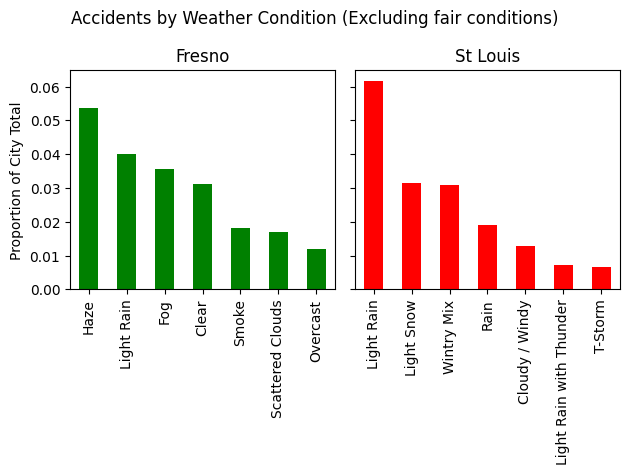

In [146]:
props_fresno = fresno["Weather_Condition"].value_counts() / fresno.shape[0]
top_fresno= props_fresno.iloc[4:11]

props_stlouis = stlouis["Weather_Condition"].value_counts() / stlouis.shape[0]
top_stlouis = props_stlouis.iloc[4:11]

fig, axes = plt.subplots(1, 2, sharey=True)
top_fresno.plot(kind='bar', ax=axes[0], color='g')
axes[0].set_title("Fresno")
axes[0].set_ylabel("Proportion of City Total")
axes[0].set_xlabel(None)

top_stlouis.plot(kind='bar', ax=axes[1], color='r')
axes[1].set_title("St Louis")
axes[1].set_xlabel(None)

plt.suptitle("Accidents by Weather Condition (Excluding fair conditions)")
plt.tight_layout()

In [149]:
props_fresno = fresno["Weather_Condition"].value_counts() / fresno.shape[0]
props_fresno.head(4)

Weather_Condition
Fair             0.365640
Partly Cloudy    0.167616
Mostly Cloudy    0.162849
Cloudy           0.073895
Name: count, dtype: float64

### Lat Long Feature Analysis

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


In [141]:
X_fresno = fresno[["Start_Lat", "Start_Lng"]]
y_fresno = fresno["severe"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

print(confusion_matrix(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[  32   30    2    0]
 [  10 4160    8    6]
 [   0   25    3    0]
 [   0   17    0    7]]
              precision    recall  f1-score   support

           1       0.76      0.50      0.60        64
           2       0.98      0.99      0.99      4184
           3       0.23      0.11      0.15        28
           4       0.54      0.29      0.38        24

    accuracy                           0.98      4300
   macro avg       0.63      0.47      0.53      4300
weighted avg       0.97      0.98      0.97      4300



In [142]:
X_stl = stlouis[["Start_Lat", "Start_Lng"]]
y_stl = stlouis["severe"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)
print(rf.oob_score_)

0.9771317829457364


In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def evaluate_city(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        oob_score=True
    )
    rf.fit(X_train, y_train)

    y_pred_proba = rf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    return auc

auc_fresno = evaluate_city(X_fresno, y_fresno)
auc_stl = evaluate_city(X_stl, y_stl)

print("Fresno AUC:", auc_fresno)
print("St Louis AUC:", auc_stl)


Fresno AUC: 0.7343207858155147
St Louis AUC: 0.7297141890749195
